In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import Libraries

In [ ]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization, GlobalAveragePooling2D # BatchNormalization is already imported here
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Pre-Processing

In [ ]:
SIZE = 256 #Constant size throughout the model

In [ ]:
train_images = []
train_labels = []

In [ ]:
for directory_path in glob.glob("/content/drive/MyDrive/aadharcards_desti/train/*"):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
#Capture test/validation data and labels into respective lists
test_images = []
test_labels = []
for directory_path in glob.glob("/content/drive/MyDrive/aadharcards_desti/test/*"):
    label1 = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label1)

In [ ]:
#Encode labels from text to integers.
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
x_test = np.array(x_test)
x_train, x_test = x_train / 255.0, x_test / 255.0

# Dataset Visualization

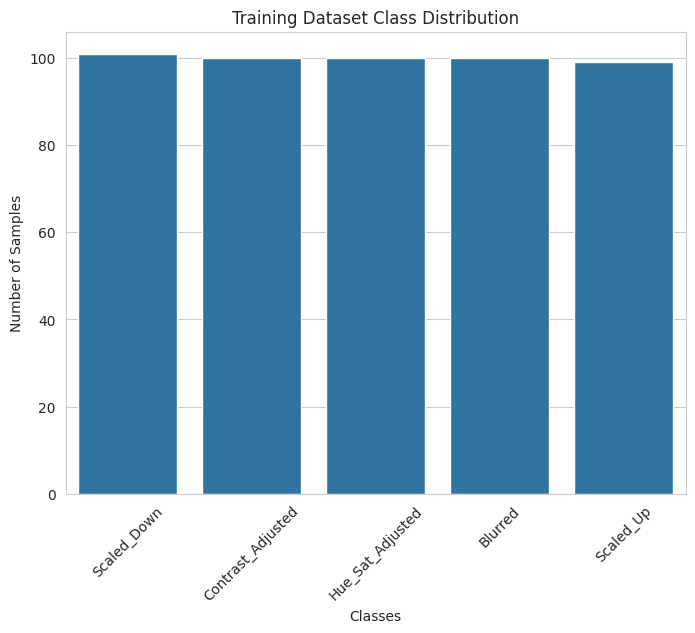

In [ ]:
train_class_distribution = pd.Series(train_labels).value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=train_class_distribution.index, y=train_class_distribution.values)
plt.title('Training Dataset Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

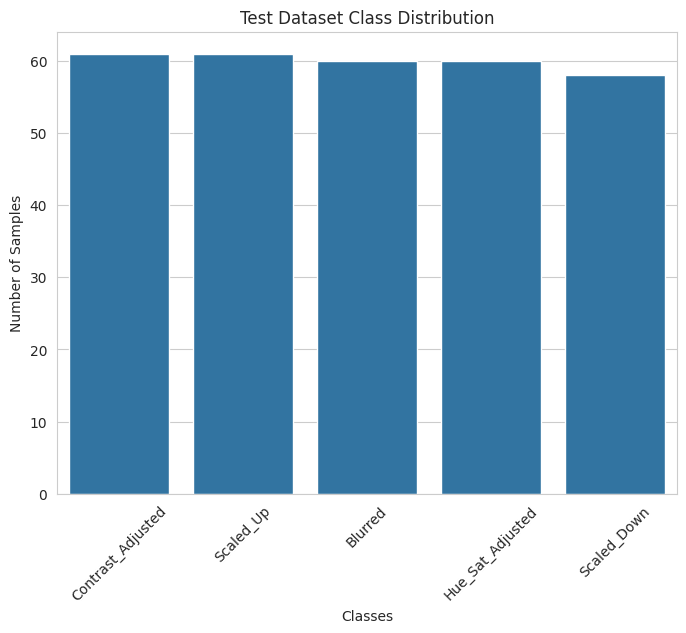

In [ ]:
test_class_distribution = pd.Series(test_labels).value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=test_class_distribution.index, y=test_class_distribution.values)
plt.title('Test Dataset Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

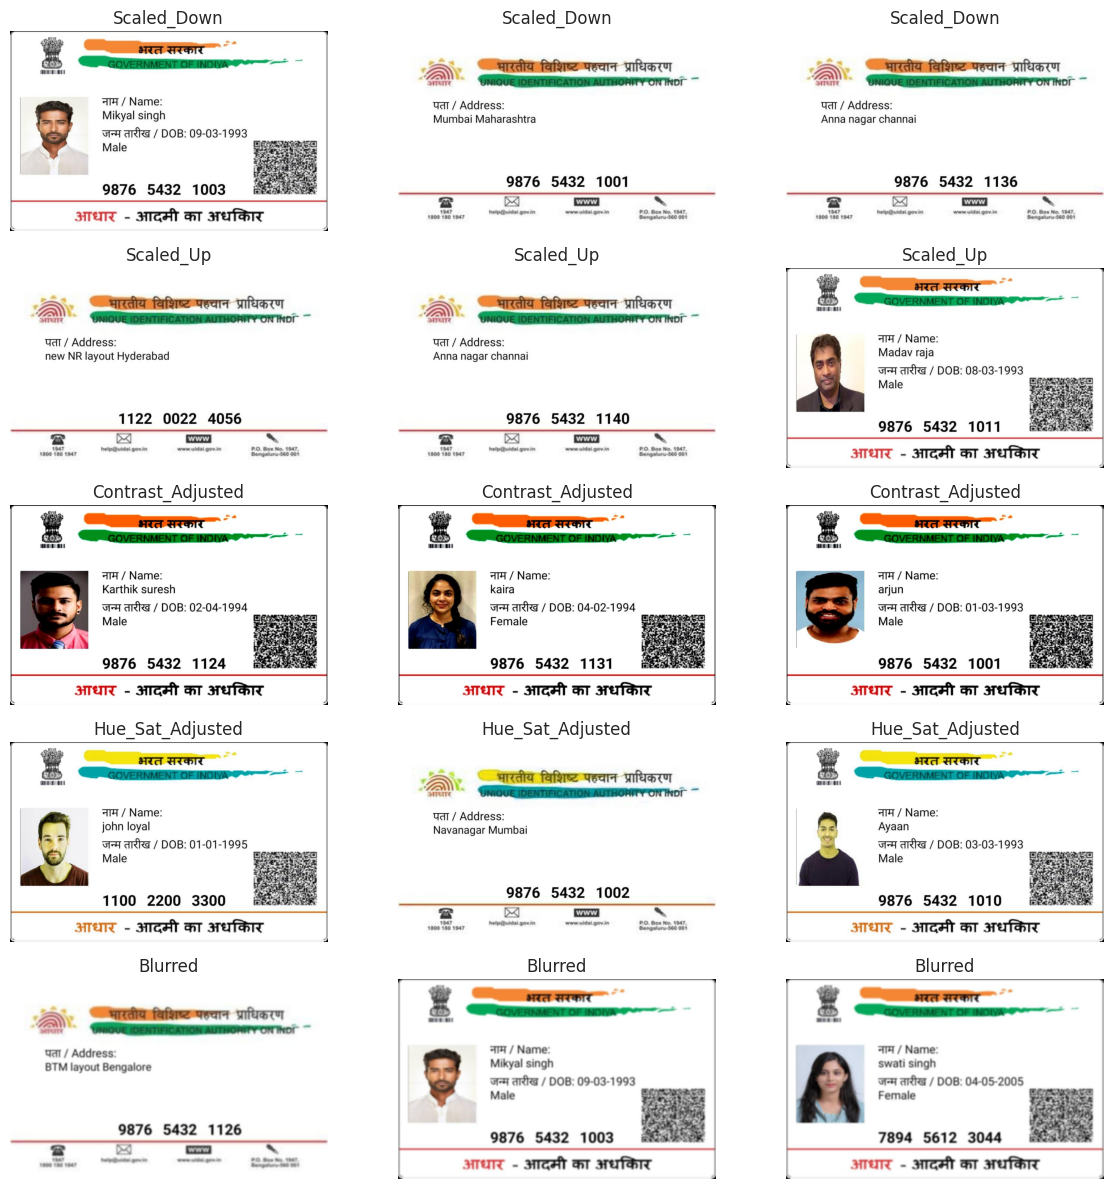

In [ ]:
import random

def display_sample_images(data_path, class_names, num_samples=3):
    plt.figure(figsize=(12, 12))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        sample_images = random.sample(glob.glob(os.path.join(class_path, "*.jpg")), num_samples)
        for j, img_path in enumerate(sample_images):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{class_name}')
    plt.tight_layout()
    plt.show()

train_path = "/content/drive/MyDrive/aadharcards_desti/train"
class_names = os.listdir(train_path)
display_sample_images(train_path, class_names)

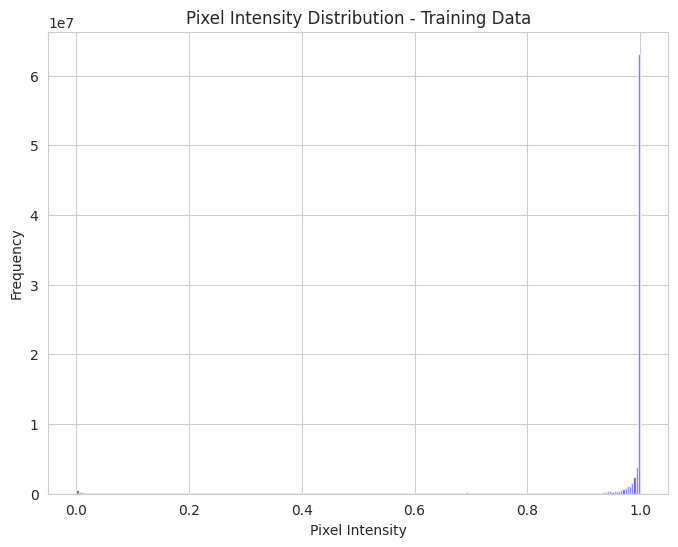

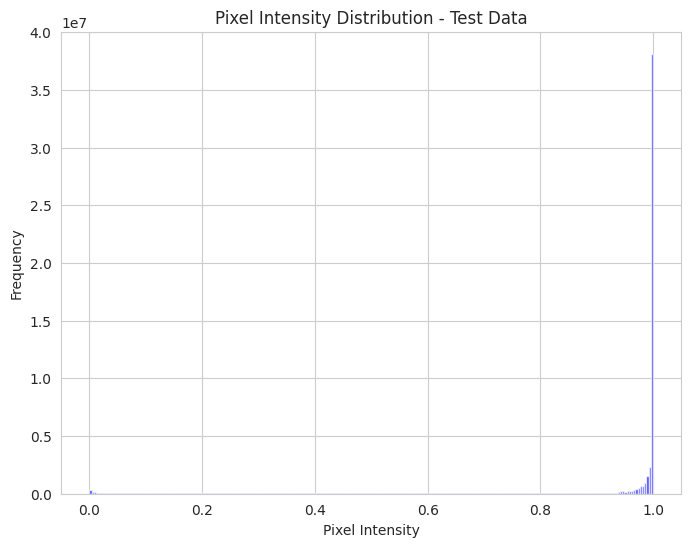

In [ ]:
def plot_pixel_intensity_histogram(images, title):
    plt.figure(figsize=(8, 6))
    pixel_values = images.ravel()
    plt.hist(pixel_values, bins=256, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_intensity_histogram(x_train, 'Pixel Intensity Distribution - Training Data')

plot_pixel_intensity_histogram(x_test, 'Pixel Intensity Distribution - Test Data')

# Model Building (VGG16 & XG-Boost)

In [ ]:
#Load model without classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#We need to make the layers non-trainable so as to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False

VGG_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

# Feature Extraction using VGG16 Model

In [ ]:
feature_extractor = VGG_model.predict(x_train)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_for_training = features

16/16 ━━━━━━━━━━━━━━━━━━━━ 374s 23s/step


# XG Boost Classifier

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

prediction = model.predict(X_test_features)

10/10 ━━━━━━━━━━━━━━━━━━━━ 228s 22s/step


# Classification Report

In [ ]:
print("Classification Report:\n", classification_report(test_labels_encoded, prediction))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      1.00      1.00        61
           2       1.00      0.95      0.97        60
           3       1.00      1.00      1.00        58
           4       1.00      1.00      1.00        61

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [ ]:
accuracy = accuracy_score(test_labels_encoded, prediction)
print("Accuracy: ", accuracy)

loss = log_loss(test_labels_encoded, model.predict_proba(X_test_features))
print("Log Loss: ", loss)

Accuracy:  0.99
Log Loss:  0.012556334680238713


# Confusion Matrix

<Axes: >

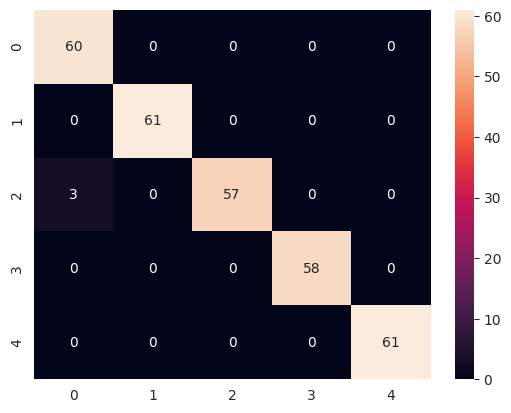

In [ ]:
prediction = model.predict(X_test_features)
cm = confusion_matrix(test_labels_encoded, prediction)
sns.heatmap(cm, annot=True)

# Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The prediction for this image is:  ['Scaled_Up']
The actual label for this image is:  Scaled_Up


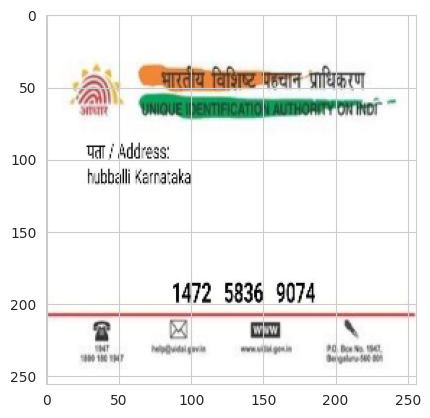

In [ ]:
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0)
input_img_feature = VGG_model.predict(input_img)
input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0]
prediction = le.inverse_transform([prediction])  # Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
The prediction for this image is:  ['Blurred']
The actual label for this image is:  Blurred


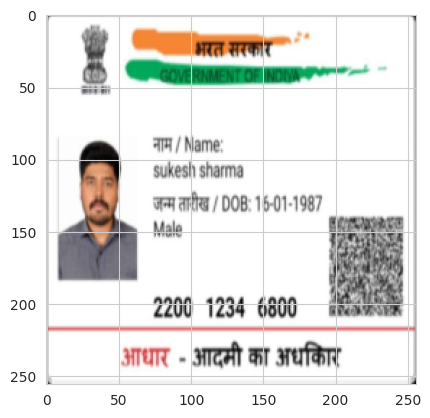

In [ ]:
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0)
input_img_feature = VGG_model.predict(input_img)
input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0]
prediction = le.inverse_transform([prediction])
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

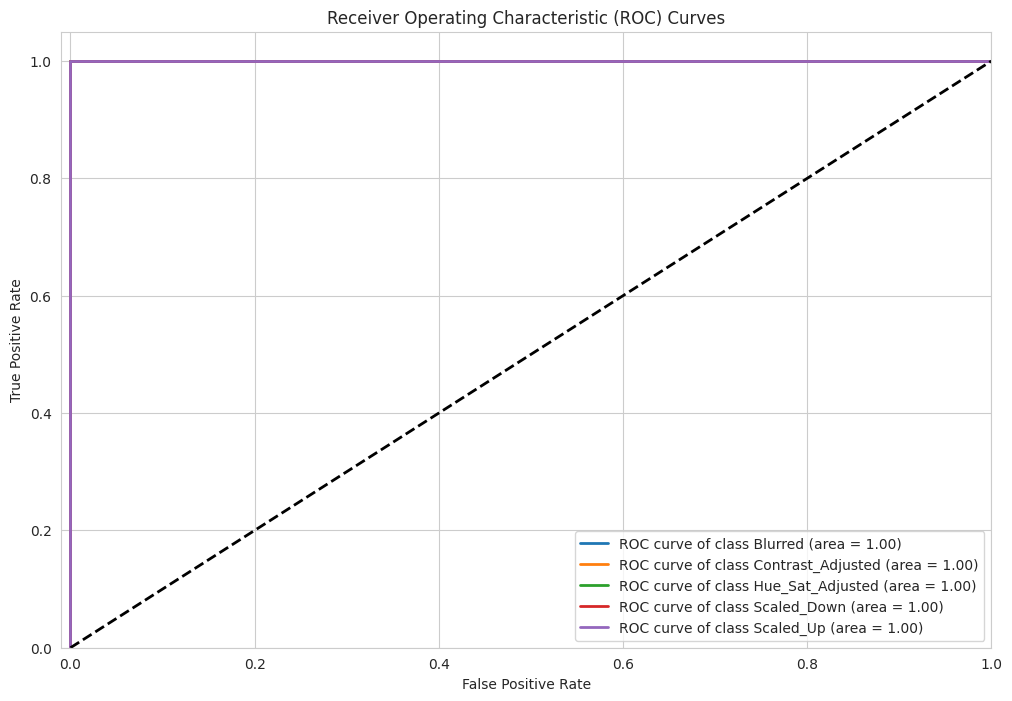

<Figure size 1000x800 with 0 Axes>

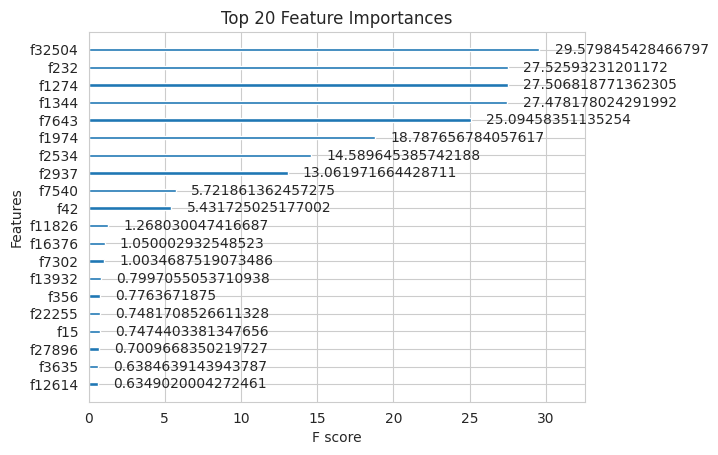

In [ ]:
# Assuming you have X_train (training features) and y_train (training labels) available
model.fit(X_for_training, y_train) # Train the model

# ROC Curves for Each Class
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output
n_classes = len(le.classes_)
y_test_binarized = label_binarize(y_test, classes=range(n_classes))
y_score = model.predict_proba(X_test_features) # Now you can get predictions

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10').colors
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.inverse_transform([i])[0], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title('Top 20 Feature Importances')
plt.show()